In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [17]:
def training_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    initializer = combinators.GuidedConditioning(init_bouncing_ball, init_proposal)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    step = combinators.GuidedConditioning(bouncing_ball_step, step_proposal)
    return foldable.Reduce(foldable.Foldable(step, initializer=initializer), lambda: range(T))

In [18]:
def posterior_model(trained_init, trained_step):
    return mcmc.reduce_resample_move_smc(trained_step, lambda: range(T), initializer=trained_init, moves=5)

02/14/2019 15:05:30 ELBO=-9.03402954e+02 at epoch 1
02/14/2019 15:05:31 ELBO=-9.16185913e+02 at epoch 2
02/14/2019 15:05:31 ELBO=-8.55548767e+02 at epoch 3
02/14/2019 15:05:32 ELBO=-7.78548096e+02 at epoch 4
02/14/2019 15:05:32 ELBO=-8.37221985e+02 at epoch 5
02/14/2019 15:05:33 ELBO=-8.17766052e+02 at epoch 6
02/14/2019 15:05:33 ELBO=-7.66121216e+02 at epoch 7
02/14/2019 15:05:33 ELBO=-8.24324890e+02 at epoch 8
02/14/2019 15:05:34 ELBO=-7.82233215e+02 at epoch 9
02/14/2019 15:05:34 ELBO=-8.00759033e+02 at epoch 10
02/14/2019 15:05:35 ELBO=-8.42996094e+02 at epoch 11
02/14/2019 15:05:35 ELBO=-7.72185547e+02 at epoch 12
02/14/2019 15:05:36 ELBO=-7.13852783e+02 at epoch 13
02/14/2019 15:05:36 ELBO=-7.86857117e+02 at epoch 14
02/14/2019 15:05:36 ELBO=-6.76131897e+02 at epoch 15
02/14/2019 15:05:37 ELBO=-6.88555054e+02 at epoch 16
02/14/2019 15:05:37 ELBO=-7.23791626e+02 at epoch 17
02/14/2019 15:05:37 ELBO=-7.52205872e+02 at epoch 18
02/14/2019 15:05:38 ELBO=-7.06167969e+02 at epoch 19
02

Epoch   530: reducing learning rate of group 0 to 5.0000e-02.


02/14/2019 15:09:05 ELBO=-5.15562927e+02 at epoch 532
02/14/2019 15:09:05 ELBO=-5.13414307e+02 at epoch 533
02/14/2019 15:09:06 ELBO=-5.25045654e+02 at epoch 534
02/14/2019 15:09:06 ELBO=-5.21978516e+02 at epoch 535
02/14/2019 15:09:07 ELBO=-4.97875183e+02 at epoch 536
02/14/2019 15:09:07 ELBO=-5.18632324e+02 at epoch 537
02/14/2019 15:09:07 ELBO=-5.16839600e+02 at epoch 538
02/14/2019 15:09:08 ELBO=-4.96852234e+02 at epoch 539
02/14/2019 15:09:08 ELBO=-4.85278412e+02 at epoch 540
02/14/2019 15:09:09 ELBO=-4.89216949e+02 at epoch 541
02/14/2019 15:09:09 ELBO=-5.05675171e+02 at epoch 542
02/14/2019 15:09:09 ELBO=-4.99269928e+02 at epoch 543
02/14/2019 15:09:10 ELBO=-5.01836182e+02 at epoch 544
02/14/2019 15:09:10 ELBO=-5.02940613e+02 at epoch 545
02/14/2019 15:09:11 ELBO=-4.86087280e+02 at epoch 546
02/14/2019 15:09:11 ELBO=-4.90461456e+02 at epoch 547
02/14/2019 15:09:11 ELBO=-4.82848236e+02 at epoch 548
02/14/2019 15:09:12 ELBO=-5.02457947e+02 at epoch 549
02/14/2019 15:09:12 ELBO=-4.

Epoch   655: reducing learning rate of group 0 to 2.5000e-02.


02/14/2019 15:09:55 ELBO=-4.60755920e+02 at epoch 657
02/14/2019 15:09:55 ELBO=-4.52148254e+02 at epoch 658
02/14/2019 15:09:55 ELBO=-4.79094086e+02 at epoch 659
02/14/2019 15:09:56 ELBO=-4.77355377e+02 at epoch 660
02/14/2019 15:09:56 ELBO=-4.79072723e+02 at epoch 661
02/14/2019 15:09:57 ELBO=-4.65163483e+02 at epoch 662
02/14/2019 15:09:57 ELBO=-4.70954315e+02 at epoch 663
02/14/2019 15:09:57 ELBO=-5.02242645e+02 at epoch 664
02/14/2019 15:09:58 ELBO=-4.71067505e+02 at epoch 665
02/14/2019 15:09:58 ELBO=-5.02985962e+02 at epoch 666
02/14/2019 15:09:59 ELBO=-4.66470917e+02 at epoch 667
02/14/2019 15:09:59 ELBO=-4.73716766e+02 at epoch 668
02/14/2019 15:09:59 ELBO=-4.62537842e+02 at epoch 669
02/14/2019 15:10:00 ELBO=-4.50616058e+02 at epoch 670
02/14/2019 15:10:00 ELBO=-4.71823578e+02 at epoch 671
02/14/2019 15:10:01 ELBO=-4.86246094e+02 at epoch 672
02/14/2019 15:10:01 ELBO=-4.63734283e+02 at epoch 673
02/14/2019 15:10:01 ELBO=-4.44054108e+02 at epoch 674
02/14/2019 15:10:02 ELBO=-4.

Epoch   794: reducing learning rate of group 0 to 1.2500e-02.


02/14/2019 15:10:49 ELBO=-4.93416779e+02 at epoch 796
02/14/2019 15:10:50 ELBO=-4.69951447e+02 at epoch 797
02/14/2019 15:10:50 ELBO=-4.66022186e+02 at epoch 798
02/14/2019 15:10:50 ELBO=-4.71396881e+02 at epoch 799
02/14/2019 15:10:51 ELBO=-4.81156708e+02 at epoch 800
02/14/2019 15:10:51 ELBO=-4.55999664e+02 at epoch 801
02/14/2019 15:10:52 ELBO=-4.89993958e+02 at epoch 802
02/14/2019 15:10:52 ELBO=-4.85696686e+02 at epoch 803
02/14/2019 15:10:53 ELBO=-4.73185303e+02 at epoch 804
02/14/2019 15:10:53 ELBO=-4.71558258e+02 at epoch 805
02/14/2019 15:10:53 ELBO=-4.73991730e+02 at epoch 806
02/14/2019 15:10:54 ELBO=-4.83631927e+02 at epoch 807
02/14/2019 15:10:54 ELBO=-4.43113739e+02 at epoch 808
02/14/2019 15:10:55 ELBO=-4.48125671e+02 at epoch 809
02/14/2019 15:10:55 ELBO=-4.60842834e+02 at epoch 810
02/14/2019 15:10:55 ELBO=-4.25788300e+02 at epoch 811
02/14/2019 15:10:56 ELBO=-4.37225555e+02 at epoch 812
02/14/2019 15:10:56 ELBO=-4.51371826e+02 at epoch 813
02/14/2019 15:10:57 ELBO=-4.

Epoch   971: reducing learning rate of group 0 to 6.2500e-03.


02/14/2019 15:12:01 ELBO=-4.67019073e+02 at epoch 973
02/14/2019 15:12:01 ELBO=-4.15315094e+02 at epoch 974
02/14/2019 15:12:01 ELBO=-4.49256805e+02 at epoch 975
02/14/2019 15:12:02 ELBO=-4.20252014e+02 at epoch 976
02/14/2019 15:12:02 ELBO=-4.75482544e+02 at epoch 977
02/14/2019 15:12:03 ELBO=-4.23154144e+02 at epoch 978
02/14/2019 15:12:03 ELBO=-4.55553314e+02 at epoch 979
02/14/2019 15:12:03 ELBO=-4.58058075e+02 at epoch 980
02/14/2019 15:12:04 ELBO=-4.62928497e+02 at epoch 981
02/14/2019 15:12:04 ELBO=-4.91326508e+02 at epoch 982
02/14/2019 15:12:05 ELBO=-4.48960297e+02 at epoch 983
02/14/2019 15:12:05 ELBO=-4.64634979e+02 at epoch 984
02/14/2019 15:12:05 ELBO=-4.78607697e+02 at epoch 985
02/14/2019 15:12:06 ELBO=-4.11843475e+02 at epoch 986
02/14/2019 15:12:06 ELBO=-4.26148010e+02 at epoch 987
02/14/2019 15:12:06 ELBO=-4.51692352e+02 at epoch 988
02/14/2019 15:12:07 ELBO=-4.35855011e+02 at epoch 989
02/14/2019 15:12:07 ELBO=-4.48957825e+02 at epoch 990
02/14/2019 15:12:08 ELBO=-4.

Epoch  1108: reducing learning rate of group 0 to 3.1250e-03.


02/14/2019 15:12:54 ELBO=-4.60720642e+02 at epoch 1110
02/14/2019 15:12:54 ELBO=-4.09291290e+02 at epoch 1111
02/14/2019 15:12:55 ELBO=-4.28284271e+02 at epoch 1112
02/14/2019 15:12:55 ELBO=-4.25058044e+02 at epoch 1113
02/14/2019 15:12:55 ELBO=-4.36978333e+02 at epoch 1114
02/14/2019 15:12:56 ELBO=-4.28226471e+02 at epoch 1115
02/14/2019 15:12:56 ELBO=-4.49048126e+02 at epoch 1116
02/14/2019 15:12:57 ELBO=-4.19582092e+02 at epoch 1117
02/14/2019 15:12:57 ELBO=-4.37626434e+02 at epoch 1118
02/14/2019 15:12:57 ELBO=-4.62022614e+02 at epoch 1119
02/14/2019 15:12:58 ELBO=-4.28180817e+02 at epoch 1120
02/14/2019 15:12:58 ELBO=-4.45841797e+02 at epoch 1121
02/14/2019 15:12:58 ELBO=-4.59713226e+02 at epoch 1122
02/14/2019 15:12:59 ELBO=-4.29989471e+02 at epoch 1123
02/14/2019 15:12:59 ELBO=-4.52515167e+02 at epoch 1124
02/14/2019 15:13:00 ELBO=-4.29977081e+02 at epoch 1125
02/14/2019 15:13:00 ELBO=-4.33138763e+02 at epoch 1126
02/14/2019 15:13:00 ELBO=-4.46382019e+02 at epoch 1127
02/14/2019

Epoch  1315: reducing learning rate of group 0 to 1.5625e-03.


02/14/2019 15:14:14 ELBO=-4.38430481e+02 at epoch 1317
02/14/2019 15:14:14 ELBO=-4.48691406e+02 at epoch 1318
02/14/2019 15:14:15 ELBO=-4.17931946e+02 at epoch 1319
02/14/2019 15:14:15 ELBO=-4.43789734e+02 at epoch 1320
02/14/2019 15:14:15 ELBO=-4.52917267e+02 at epoch 1321
02/14/2019 15:14:16 ELBO=-4.48047577e+02 at epoch 1322
02/14/2019 15:14:16 ELBO=-4.06817352e+02 at epoch 1323
02/14/2019 15:14:16 ELBO=-4.40363281e+02 at epoch 1324
02/14/2019 15:14:17 ELBO=-4.44159607e+02 at epoch 1325
02/14/2019 15:14:17 ELBO=-4.35142578e+02 at epoch 1326
02/14/2019 15:14:18 ELBO=-4.62047546e+02 at epoch 1327
02/14/2019 15:14:18 ELBO=-4.31430725e+02 at epoch 1328
02/14/2019 15:14:18 ELBO=-4.37104767e+02 at epoch 1329
02/14/2019 15:14:19 ELBO=-4.40776184e+02 at epoch 1330
02/14/2019 15:14:19 ELBO=-4.33002075e+02 at epoch 1331
02/14/2019 15:14:19 ELBO=-4.39044220e+02 at epoch 1332
02/14/2019 15:14:20 ELBO=-4.24629150e+02 at epoch 1333
02/14/2019 15:14:20 ELBO=-4.33905823e+02 at epoch 1334
02/14/2019

Epoch  1416: reducing learning rate of group 0 to 7.8125e-04.


02/14/2019 15:14:52 ELBO=-4.27393921e+02 at epoch 1418
02/14/2019 15:14:53 ELBO=-4.39862671e+02 at epoch 1419
02/14/2019 15:14:53 ELBO=-4.37278015e+02 at epoch 1420
02/14/2019 15:14:54 ELBO=-4.27370880e+02 at epoch 1421
02/14/2019 15:14:54 ELBO=-4.21520355e+02 at epoch 1422
02/14/2019 15:14:54 ELBO=-4.34240204e+02 at epoch 1423
02/14/2019 15:14:55 ELBO=-4.17584991e+02 at epoch 1424
02/14/2019 15:14:55 ELBO=-4.38488800e+02 at epoch 1425
02/14/2019 15:14:55 ELBO=-4.38062317e+02 at epoch 1426
02/14/2019 15:14:56 ELBO=-4.31117493e+02 at epoch 1427
02/14/2019 15:14:56 ELBO=-4.18830780e+02 at epoch 1428
02/14/2019 15:14:57 ELBO=-4.16829346e+02 at epoch 1429
02/14/2019 15:14:57 ELBO=-4.23595703e+02 at epoch 1430
02/14/2019 15:14:57 ELBO=-4.16257019e+02 at epoch 1431
02/14/2019 15:14:58 ELBO=-4.24650269e+02 at epoch 1432
02/14/2019 15:14:58 ELBO=-4.24208038e+02 at epoch 1433
02/14/2019 15:14:58 ELBO=-4.54354279e+02 at epoch 1434
02/14/2019 15:14:59 ELBO=-4.24769684e+02 at epoch 1435
02/14/2019

Epoch  1517: reducing learning rate of group 0 to 3.9063e-04.


02/14/2019 15:15:31 ELBO=-4.42504425e+02 at epoch 1519
02/14/2019 15:15:32 ELBO=-4.13750244e+02 at epoch 1520
02/14/2019 15:15:32 ELBO=-4.28493683e+02 at epoch 1521
02/14/2019 15:15:32 ELBO=-4.55169098e+02 at epoch 1522
02/14/2019 15:15:33 ELBO=-4.30281769e+02 at epoch 1523
02/14/2019 15:15:33 ELBO=-4.22566132e+02 at epoch 1524
02/14/2019 15:15:33 ELBO=-4.10109619e+02 at epoch 1525
02/14/2019 15:15:34 ELBO=-4.29203522e+02 at epoch 1526
02/14/2019 15:15:34 ELBO=-4.33328583e+02 at epoch 1527
02/14/2019 15:15:35 ELBO=-4.19243713e+02 at epoch 1528
02/14/2019 15:15:35 ELBO=-4.17681946e+02 at epoch 1529
02/14/2019 15:15:36 ELBO=-4.17363068e+02 at epoch 1530
02/14/2019 15:15:36 ELBO=-4.39526123e+02 at epoch 1531
02/14/2019 15:15:37 ELBO=-4.26280334e+02 at epoch 1532
02/14/2019 15:15:37 ELBO=-4.36399292e+02 at epoch 1533
02/14/2019 15:15:37 ELBO=-4.27225586e+02 at epoch 1534
02/14/2019 15:15:38 ELBO=-4.27367493e+02 at epoch 1535
02/14/2019 15:15:38 ELBO=-4.29378571e+02 at epoch 1536
02/14/2019

Epoch  1618: reducing learning rate of group 0 to 1.9531e-04.


02/14/2019 15:16:10 ELBO=-4.18065491e+02 at epoch 1620
02/14/2019 15:16:11 ELBO=-4.21932770e+02 at epoch 1621
02/14/2019 15:16:11 ELBO=-4.51137177e+02 at epoch 1622
02/14/2019 15:16:12 ELBO=-4.40888367e+02 at epoch 1623
02/14/2019 15:16:12 ELBO=-4.37865601e+02 at epoch 1624
02/14/2019 15:16:12 ELBO=-4.37576141e+02 at epoch 1625
02/14/2019 15:16:13 ELBO=-4.07391846e+02 at epoch 1626
02/14/2019 15:16:13 ELBO=-4.14736847e+02 at epoch 1627
02/14/2019 15:16:13 ELBO=-4.11927460e+02 at epoch 1628
02/14/2019 15:16:14 ELBO=-4.17683319e+02 at epoch 1629
02/14/2019 15:16:14 ELBO=-4.14343292e+02 at epoch 1630
02/14/2019 15:16:15 ELBO=-4.27383240e+02 at epoch 1631
02/14/2019 15:16:15 ELBO=-4.33602936e+02 at epoch 1632
02/14/2019 15:16:15 ELBO=-4.23184753e+02 at epoch 1633
02/14/2019 15:16:16 ELBO=-4.43118225e+02 at epoch 1634
02/14/2019 15:16:16 ELBO=-4.48427185e+02 at epoch 1635
02/14/2019 15:16:17 ELBO=-4.26215912e+02 at epoch 1636
02/14/2019 15:16:17 ELBO=-4.26317505e+02 at epoch 1637
02/14/2019

Epoch  1719: reducing learning rate of group 0 to 9.7656e-05.


02/14/2019 15:16:50 ELBO=-4.10069214e+02 at epoch 1721
02/14/2019 15:16:50 ELBO=-4.16942780e+02 at epoch 1722
02/14/2019 15:16:51 ELBO=-4.05809265e+02 at epoch 1723
02/14/2019 15:16:51 ELBO=-4.26253052e+02 at epoch 1724
02/14/2019 15:16:52 ELBO=-4.32429230e+02 at epoch 1725
02/14/2019 15:16:52 ELBO=-4.45346466e+02 at epoch 1726
02/14/2019 15:16:52 ELBO=-4.30645538e+02 at epoch 1727
02/14/2019 15:16:53 ELBO=-4.47450165e+02 at epoch 1728
02/14/2019 15:16:53 ELBO=-4.54457489e+02 at epoch 1729
02/14/2019 15:16:54 ELBO=-4.17788330e+02 at epoch 1730
02/14/2019 15:16:54 ELBO=-4.25222076e+02 at epoch 1731
02/14/2019 15:16:54 ELBO=-4.31522156e+02 at epoch 1732
02/14/2019 15:16:55 ELBO=-4.02505646e+02 at epoch 1733
02/14/2019 15:16:55 ELBO=-4.26442322e+02 at epoch 1734
02/14/2019 15:16:56 ELBO=-4.21182587e+02 at epoch 1735
02/14/2019 15:16:56 ELBO=-4.13997833e+02 at epoch 1736
02/14/2019 15:16:56 ELBO=-4.11197479e+02 at epoch 1737
02/14/2019 15:16:57 ELBO=-4.42108063e+02 at epoch 1738
02/14/2019

Epoch  1820: reducing learning rate of group 0 to 4.8828e-05.


02/14/2019 15:17:29 ELBO=-4.29204041e+02 at epoch 1822
02/14/2019 15:17:30 ELBO=-4.28392639e+02 at epoch 1823
02/14/2019 15:17:30 ELBO=-4.11975494e+02 at epoch 1824
02/14/2019 15:17:31 ELBO=-4.18482727e+02 at epoch 1825
02/14/2019 15:17:31 ELBO=-4.14359680e+02 at epoch 1826
02/14/2019 15:17:31 ELBO=-4.47788422e+02 at epoch 1827
02/14/2019 15:17:32 ELBO=-4.27345734e+02 at epoch 1828
02/14/2019 15:17:32 ELBO=-4.38233398e+02 at epoch 1829
02/14/2019 15:17:33 ELBO=-4.18364258e+02 at epoch 1830
02/14/2019 15:17:33 ELBO=-4.34977631e+02 at epoch 1831
02/14/2019 15:17:33 ELBO=-4.13267792e+02 at epoch 1832
02/14/2019 15:17:34 ELBO=-4.36015533e+02 at epoch 1833
02/14/2019 15:17:34 ELBO=-4.16227417e+02 at epoch 1834
02/14/2019 15:17:34 ELBO=-4.23775085e+02 at epoch 1835
02/14/2019 15:17:35 ELBO=-4.40738251e+02 at epoch 1836
02/14/2019 15:17:35 ELBO=-4.33856995e+02 at epoch 1837
02/14/2019 15:17:36 ELBO=-4.20999084e+02 at epoch 1838
02/14/2019 15:17:36 ELBO=-4.40756470e+02 at epoch 1839
02/14/2019

Epoch  1921: reducing learning rate of group 0 to 2.4414e-05.


02/14/2019 15:18:09 ELBO=-4.14765869e+02 at epoch 1923
02/14/2019 15:18:09 ELBO=-4.42632111e+02 at epoch 1924
02/14/2019 15:18:10 ELBO=-4.26737305e+02 at epoch 1925
02/14/2019 15:18:10 ELBO=-4.34458588e+02 at epoch 1926
02/14/2019 15:18:11 ELBO=-4.27060059e+02 at epoch 1927
02/14/2019 15:18:11 ELBO=-4.31302612e+02 at epoch 1928
02/14/2019 15:18:11 ELBO=-4.09891602e+02 at epoch 1929
02/14/2019 15:18:12 ELBO=-4.41898895e+02 at epoch 1930
02/14/2019 15:18:12 ELBO=-4.48465179e+02 at epoch 1931
02/14/2019 15:18:13 ELBO=-3.92795258e+02 at epoch 1932
02/14/2019 15:18:13 ELBO=-4.03621674e+02 at epoch 1933
02/14/2019 15:18:13 ELBO=-4.28298889e+02 at epoch 1934
02/14/2019 15:18:14 ELBO=-4.39205261e+02 at epoch 1935
02/14/2019 15:18:14 ELBO=-4.08894318e+02 at epoch 1936
02/14/2019 15:18:14 ELBO=-4.31868896e+02 at epoch 1937
02/14/2019 15:18:15 ELBO=-4.39221100e+02 at epoch 1938
02/14/2019 15:18:15 ELBO=-4.32328125e+02 at epoch 1939
02/14/2019 15:18:16 ELBO=-4.38351379e+02 at epoch 1940
02/14/2019

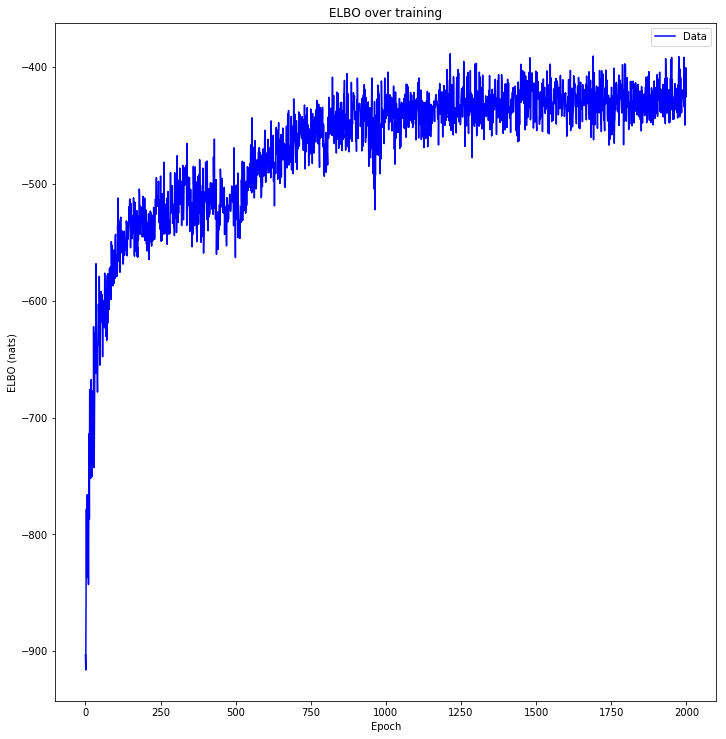

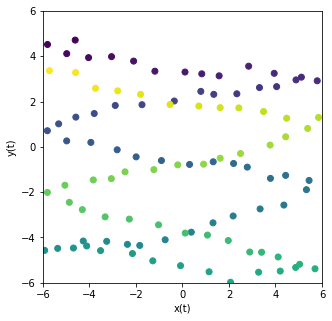

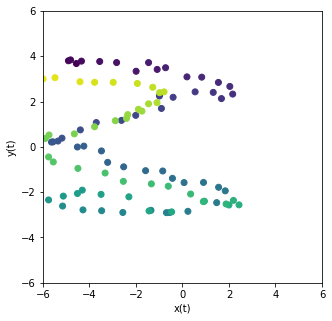

In [19]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 2000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = posterior_model(importance_sampler.folder._initializer, importance_sampler.folder.operator)
    (dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [20]:
trained_params

"{'dynamics__loc': 'tensor([[ 0.0062,  0.0062],\n        [-0.0014,  0.0020]], grad_fn=<CloneBackward>)', 'dynamics__scale': 'tensor([[-3.2835, -3.0883],\n        [-3.8600, -3.7056]], grad_fn=<CloneBackward>)', 'noise__loc': 'tensor([ 0.2338, -0.2763], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.1163, -1.7788], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-0.1987,  0.0000],\n        [-0.3194, -0.5296]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-3.4407,  3.8918], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-0.0619, -2.1715], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-1.9747, -0.6837], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-1.2899,  0.2632],\n        [-0.3186,  0.0949],\n        [ 0.4881,  0.0263],\n        [ 0.9995, -0.0671],\n        [ 1.0659, -0.0404],\n        [ 1.0199, -0.1742],\n        [ 0.9934, -0.0320],\n        [ 0.9860, -0.1753],\n        [ 1.0572, -0.1367],\n        [ 1.2222,  0.017

In [21]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-4.6130,  4.7157])
Position at time 1 tensor([-5.8043,  4.5223])
Position at time 2 tensor([-4.9774,  4.1172])
Position at time 3 tensor([-4.0373,  3.9415])
Position at time 4 tensor([-3.0499,  3.9851])
Position at time 5 tensor([-2.1003,  3.7885])
Position at time 6 tensor([-1.1851,  3.3430])
Position at time 7 tensor([0.1099, 3.3051])
Position at time 8 tensor([0.8314, 3.2264])
Position at time 9 tensor([1.5780, 3.1384])
Position at time 10 tensor([2.8473, 3.5633])
Position at time 11 tensor([3.9468, 3.2483])
Position at time 12 tensor([5.1153, 3.0789])
Position at time 13 tensor([5.7963, 2.9184])
Position at time 14 tensor([4.8839, 2.9584])
Position at time 15 tensor([4.0506, 2.6603])
Position at time 16 tensor([3.3133, 2.6193])
Position at time 17 tensor([2.3396, 2.3449])
Position at time 18 tensor([1.3480, 2.3205])
Position at time 19 tensor([0.7909, 2.4511])
Position at time 20 tensor([-0.3511,  2.0267])
Position at time 21 tensor([-1.7399,  1.8632])
Po

In [22]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-4.5628,  3.6807])
Inferred position at time 1 tensor([-4.9034,  3.8021])
Inferred position at time 2 tensor([-4.8126,  3.8415])
Inferred position at time 3 tensor([-4.3440,  3.7871])
Inferred position at time 4 tensor([-3.5586,  3.7714])
Inferred position at time 5 tensor([-2.8320,  3.7245])
Inferred position at time 6 tensor([-1.9931,  3.3395])
Inferred position at time 7 tensor([-1.0867,  3.4208])
Inferred position at time 8 tensor([-1.4572,  3.7218])
Inferred position at time 9 tensor([-0.7262,  3.4959])
Inferred position at time 10 tensor([0.1938, 3.0922])
Inferred position at time 11 tensor([0.8290, 3.0795])
Inferred position at time 12 tensor([1.5465, 2.8459])
Inferred position at time 13 tensor([2.0378, 2.6695])
Inferred position at time 14 tensor([2.1613, 2.3318])
Inferred position at time 15 tensor([1.6770, 2.1332])
Inferred position at time 16 tensor([1.3242, 2.4063])
Inferred position at time 17 tensor([0.5452, 2.4305])
Inferred position 